# Network analysis

In the present notebook, we analyze the trained weights of a given network to find why it fails to classify certain images correctly.

In [61]:
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from matplotlib import pyplot as plt
from matplotlib import rc

# disable latex (otherwise there is an error in the plots later)
rc('text', usetex=False)

# lookup class name associates with a label, i.e. class_names[3] -> 'cat'
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

batch_size = 32
num_classes = len(class_names)

In [39]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# normalize images from integer [0, 255] to float [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

print(f'shape: {x_train.shape}, num train samples: {len(x_train)}, num test samples: {len(x_test)}')

shape: (50000, 32, 32, 3), num train samples: 50000, num test samples: 10000


In [40]:
# to load weights, we need to first define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Activation('relu'),
    Dense(num_classes, activation='softmax'),
])

# loads weights into the model
model.load_weights('keras_cifar10_trained_model.h5')

## 1 Identification of false classifications

In the previous steps, we loaded weights into our model and loaded the dataset. Now, we want to identify elements from the testing dataset where our model fails to classify these elements correctly.

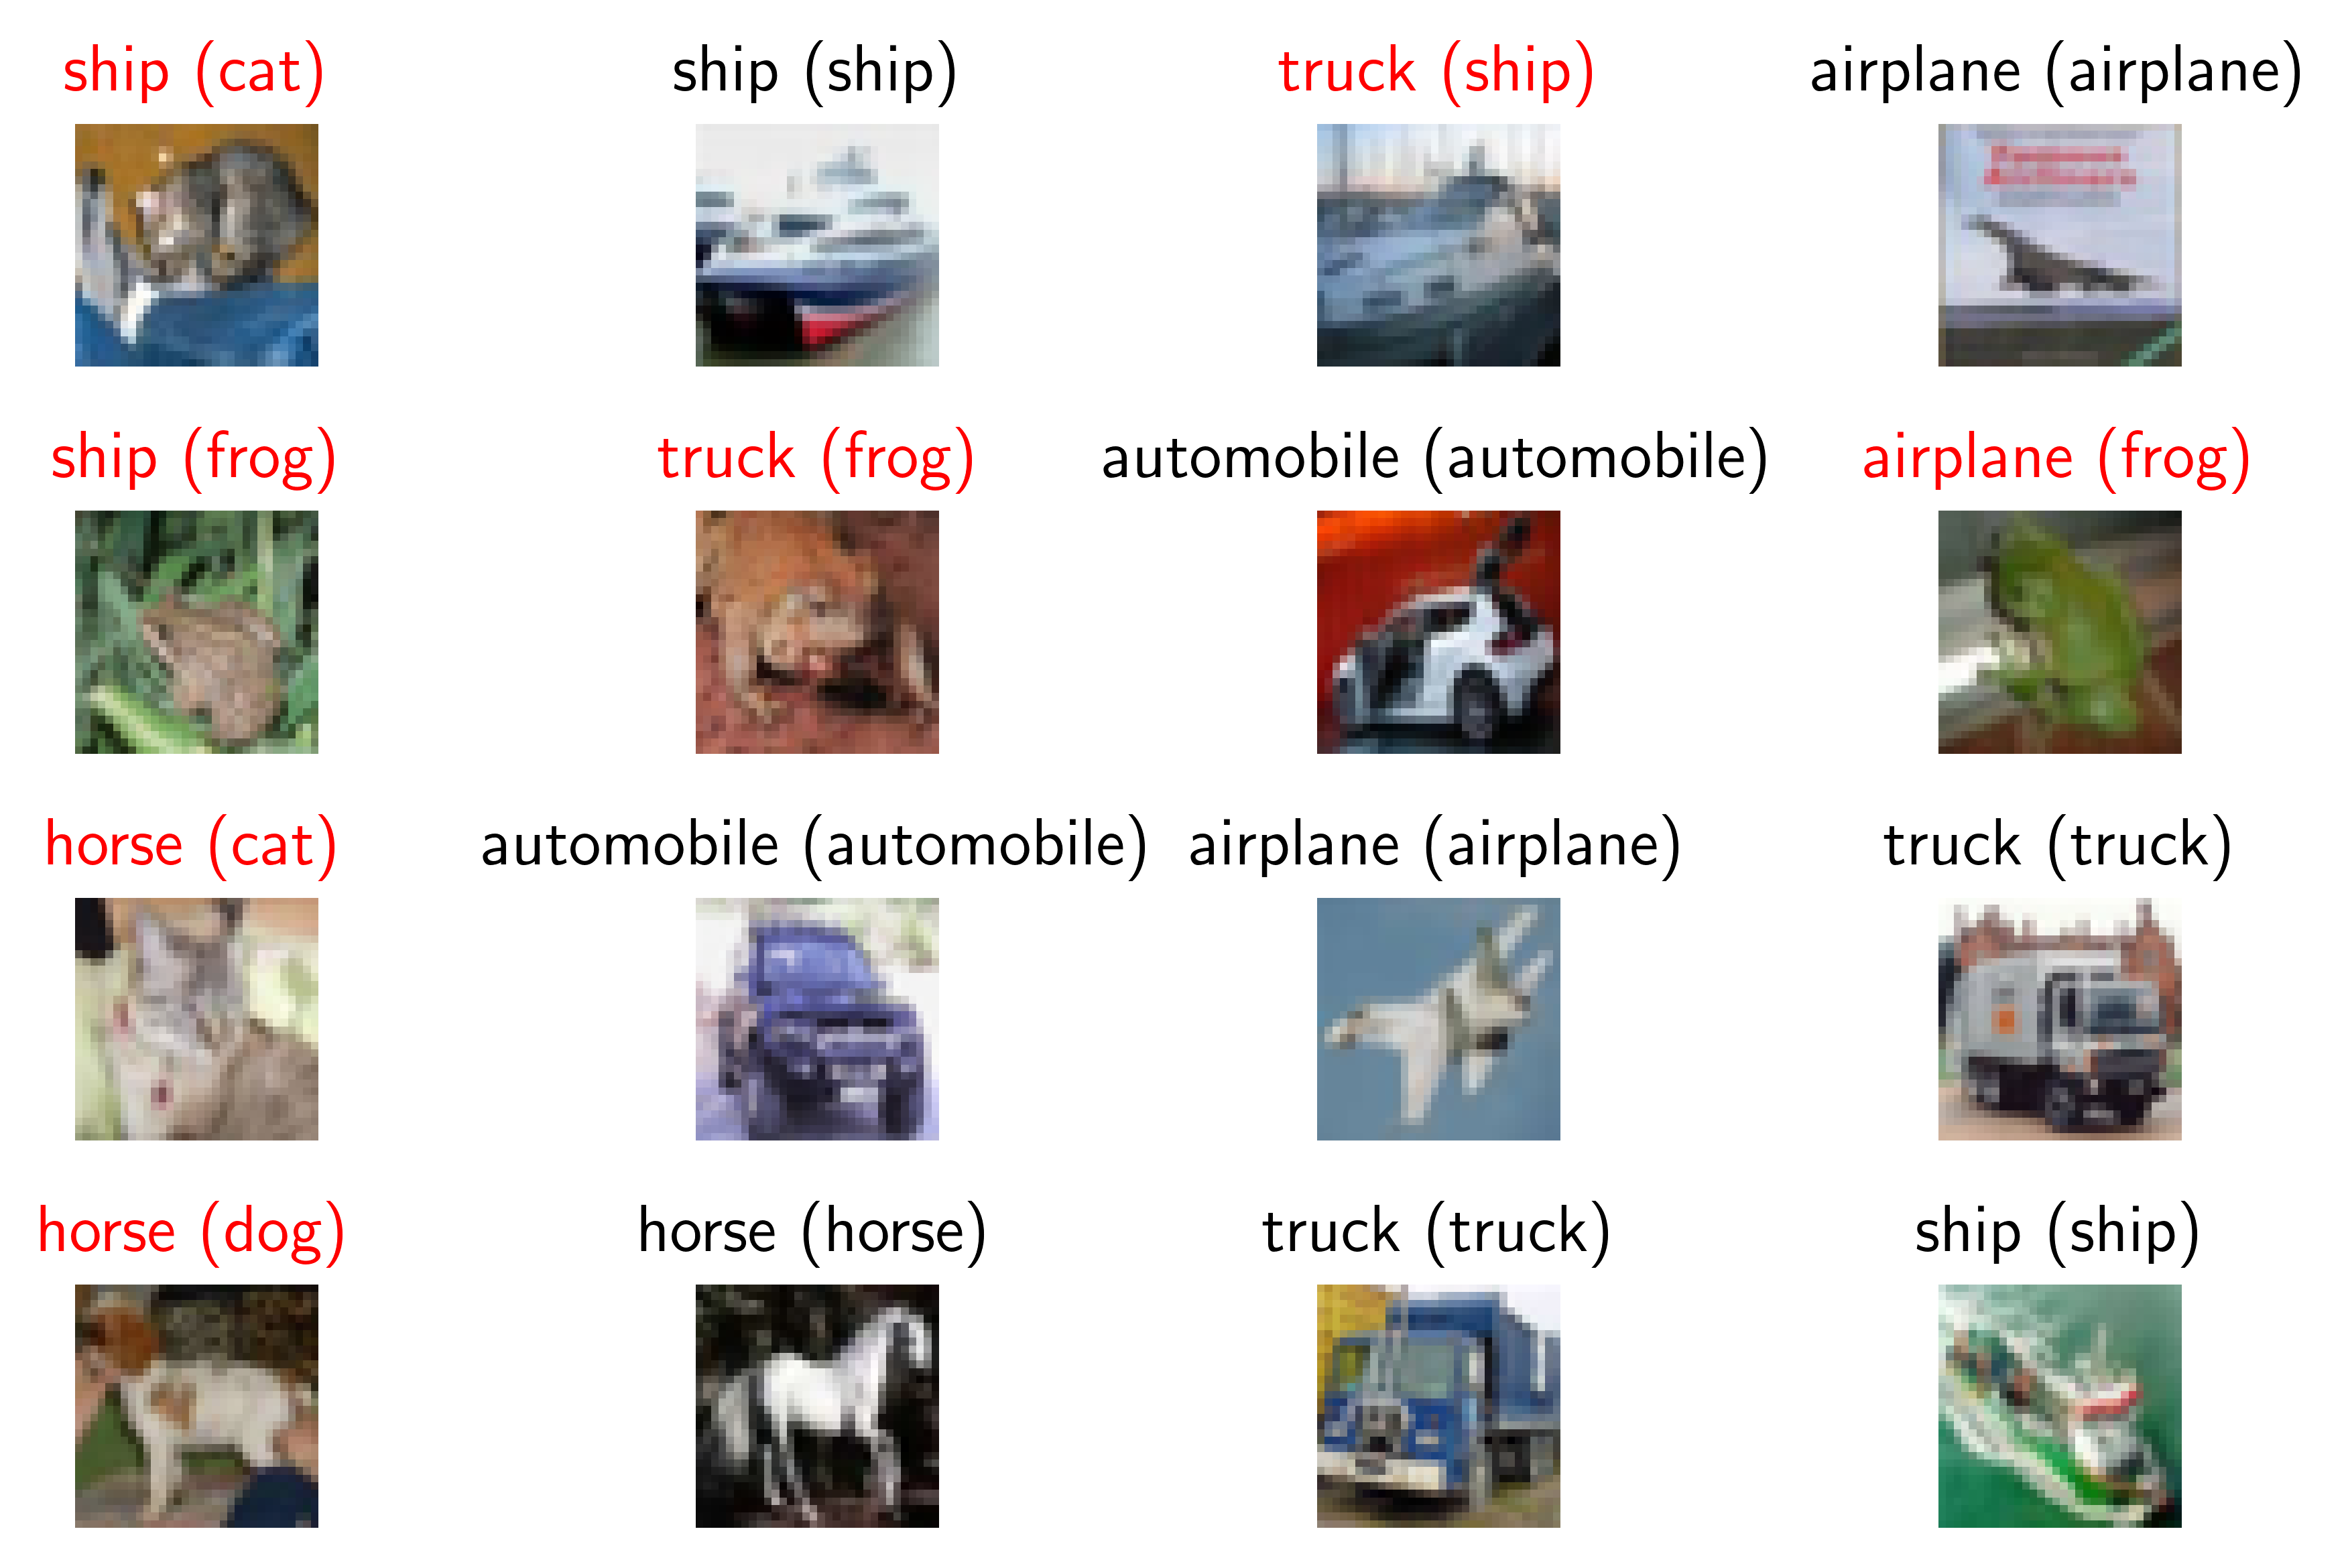

In [43]:
fig, axes = plt.subplots(nrows=4, ncols=4, dpi=300)

for ax, (image, label) in zip(axes.reshape(-1), zip(x_test, y_test)):
    pred = np.argmax(model.predict(image[np.newaxis]))

    pred_class_name = classes[pred]
    true_class_name = classes[label[0]]

    color = 'black'
    if pred_class_name != true_class_name:
        color = 'red'

    ax.imshow(image, interpolation='nearest')
    ax.set_axis_off()
    ax.set_title(f'{pred_class_name} ({true_class_name})', color=color)

plt.tight_layout()
plt.show()

In the above image grid, the predicted label is written above the corresponding image. Next to the predicted label in brackets, we find the true label. False classifications are highlighted red.

In the following, we will focus on the `frog` class as in the above image grid, there are three frogs that the model did not detect.

## Visualize activations

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)         

Only the convolutional and dense layers contain trainable parameters. Of these two only the convolutional layers can be visualized as images.

In [142]:
# we create a new model that outputs the result of the intermediate convolution layers of our original model
intermediate = Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers if layer.name.startswith('conv2d')])

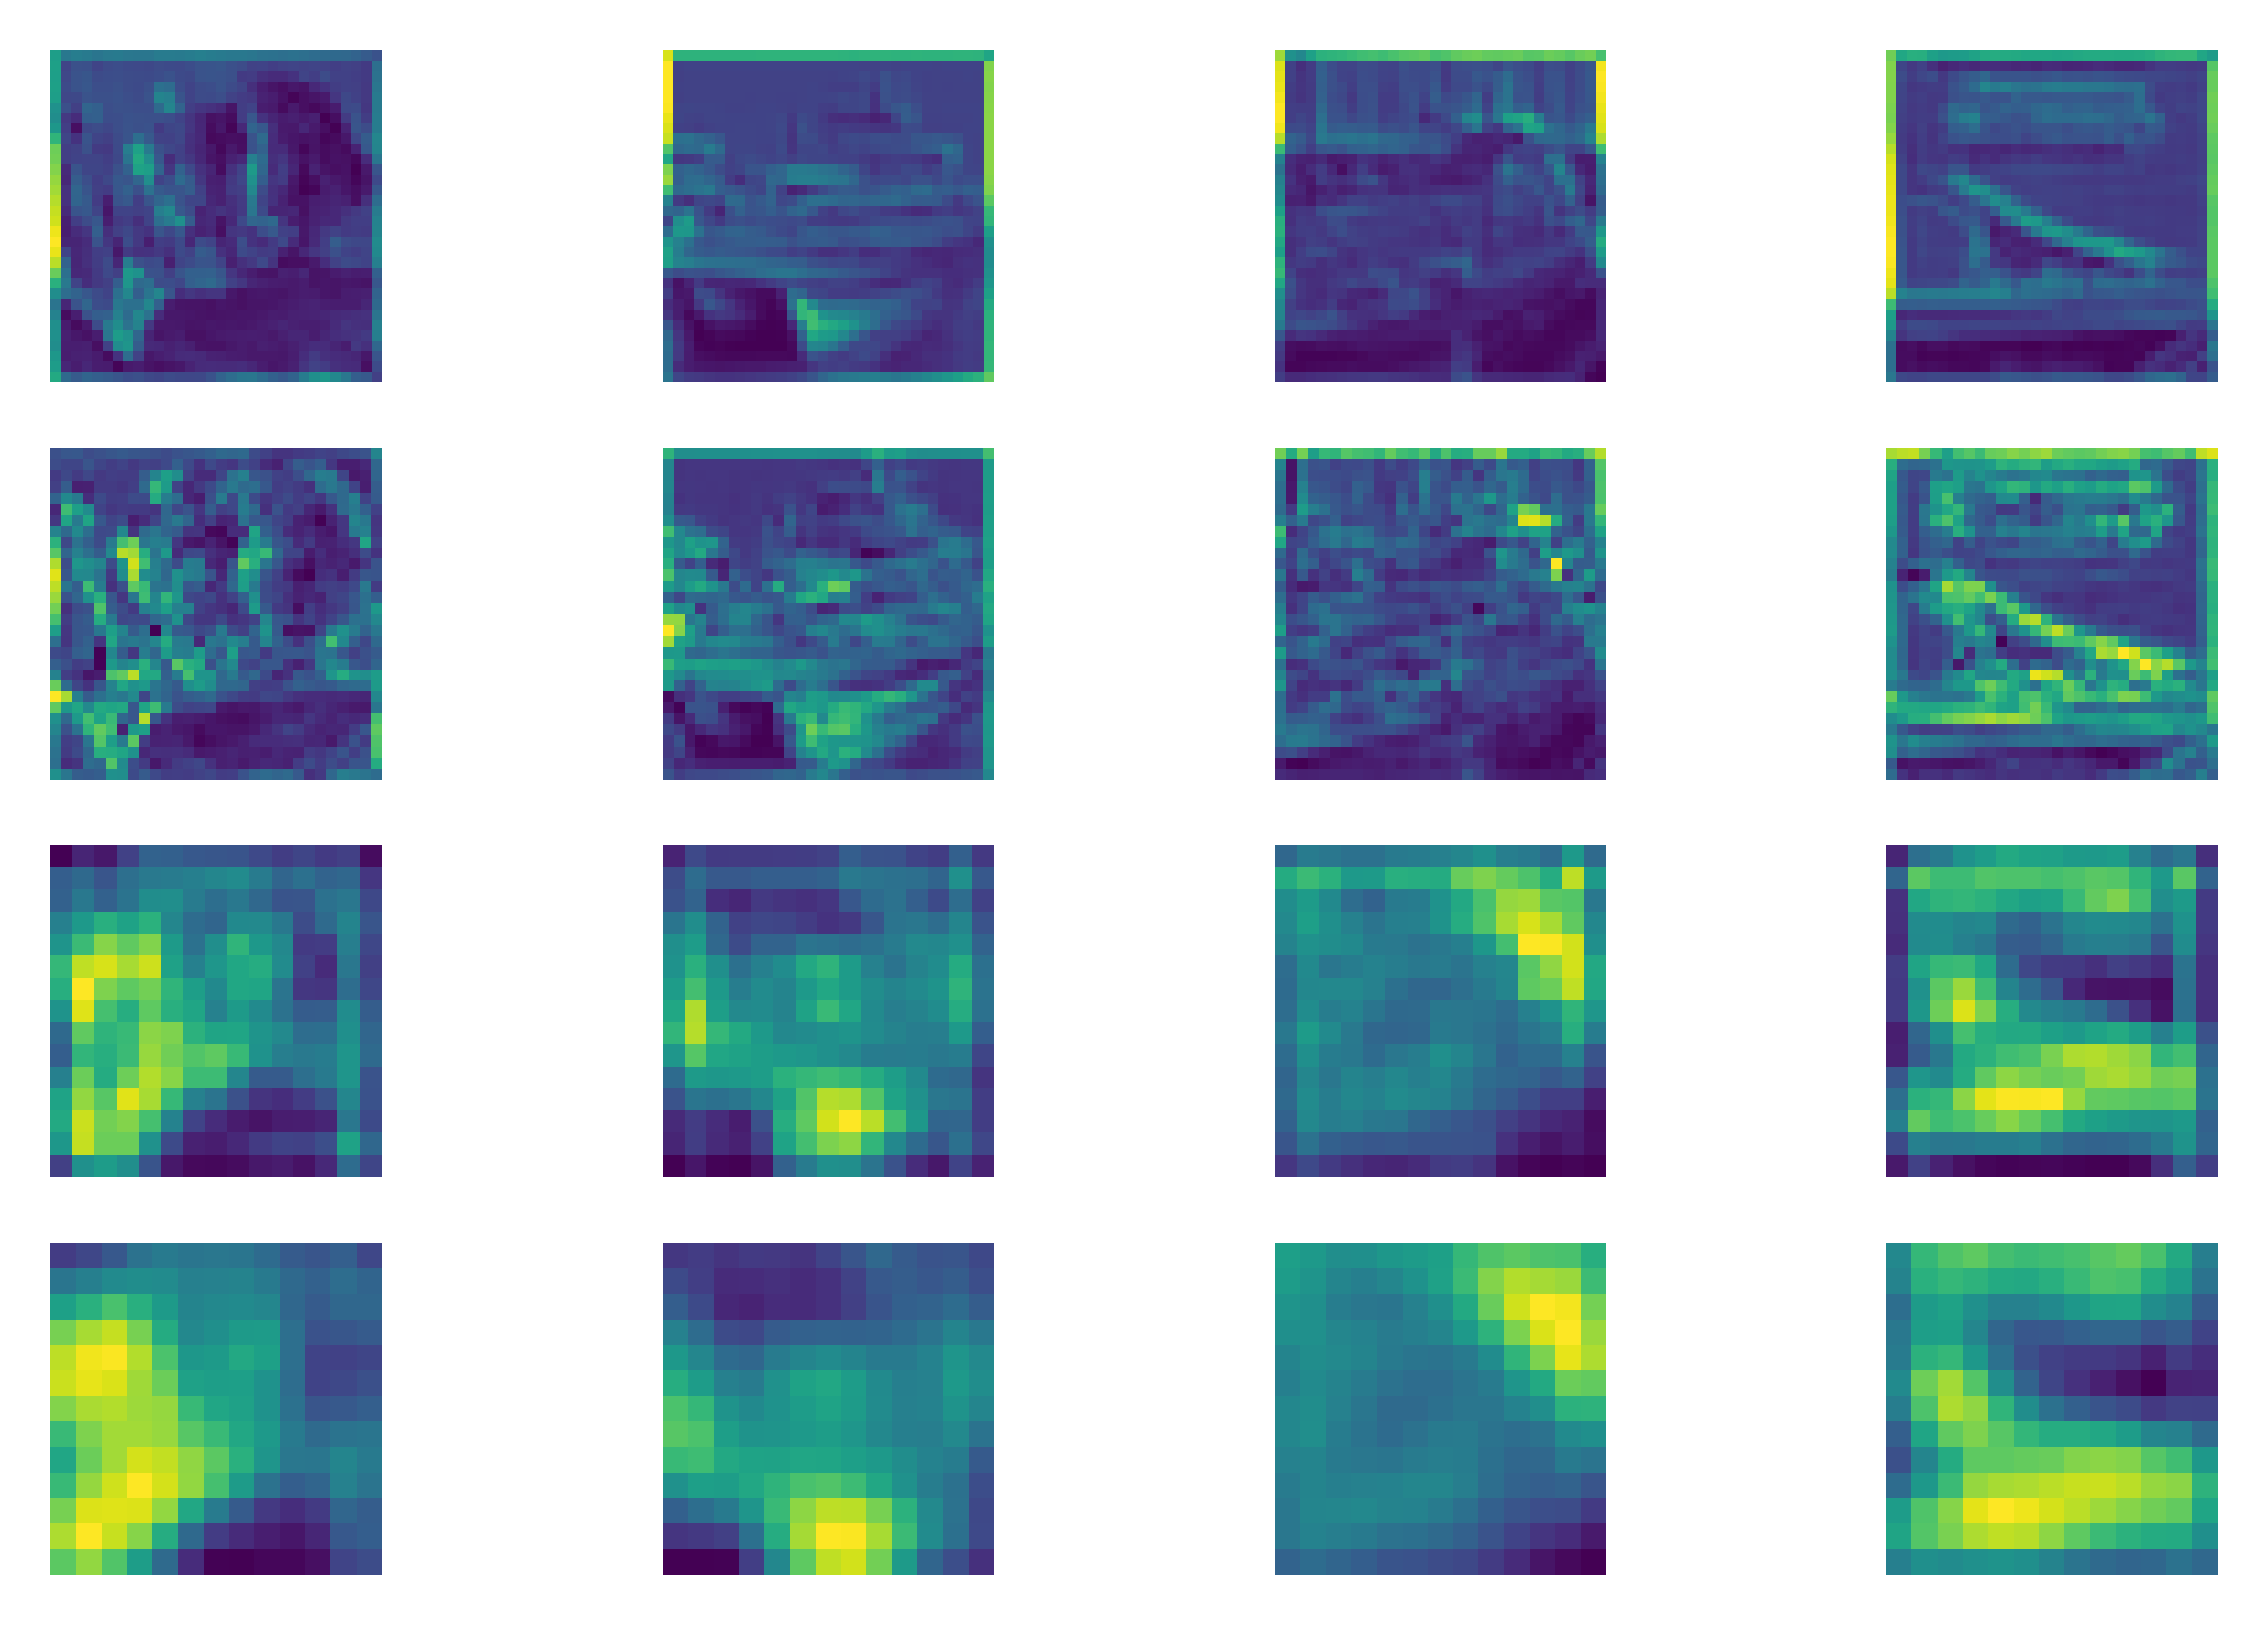

In [143]:
# average over the channel dimension of the intermediate outputs for the first four images
activations = [output.mean(axis=-1) for output in intermediate.predict(x_test[:4])]

fig, axes = plt.subplots(nrows=4, ncols=4, dpi=300)

for i in range(len(axes)):
    for j, ax in enumerate(axes[i]):
        ax.imshow(activations[i][j], interpolation='nearest')
        ax.set_axis_off()

plt.show()

The above image grid shows the averaged activation output of the first seven layers for the first four different images.

The first (convolutional) layer appears to perform edge detection in that edges of the images are highlighted.
For the jet (outer right) we see that the second convolutional layer finds the edges of the jet.
Subsequent outputs are difficult to interpet.

In [144]:
conv1, conv2, conv3, conv4 = intermediate.predict(x_test[3:4])

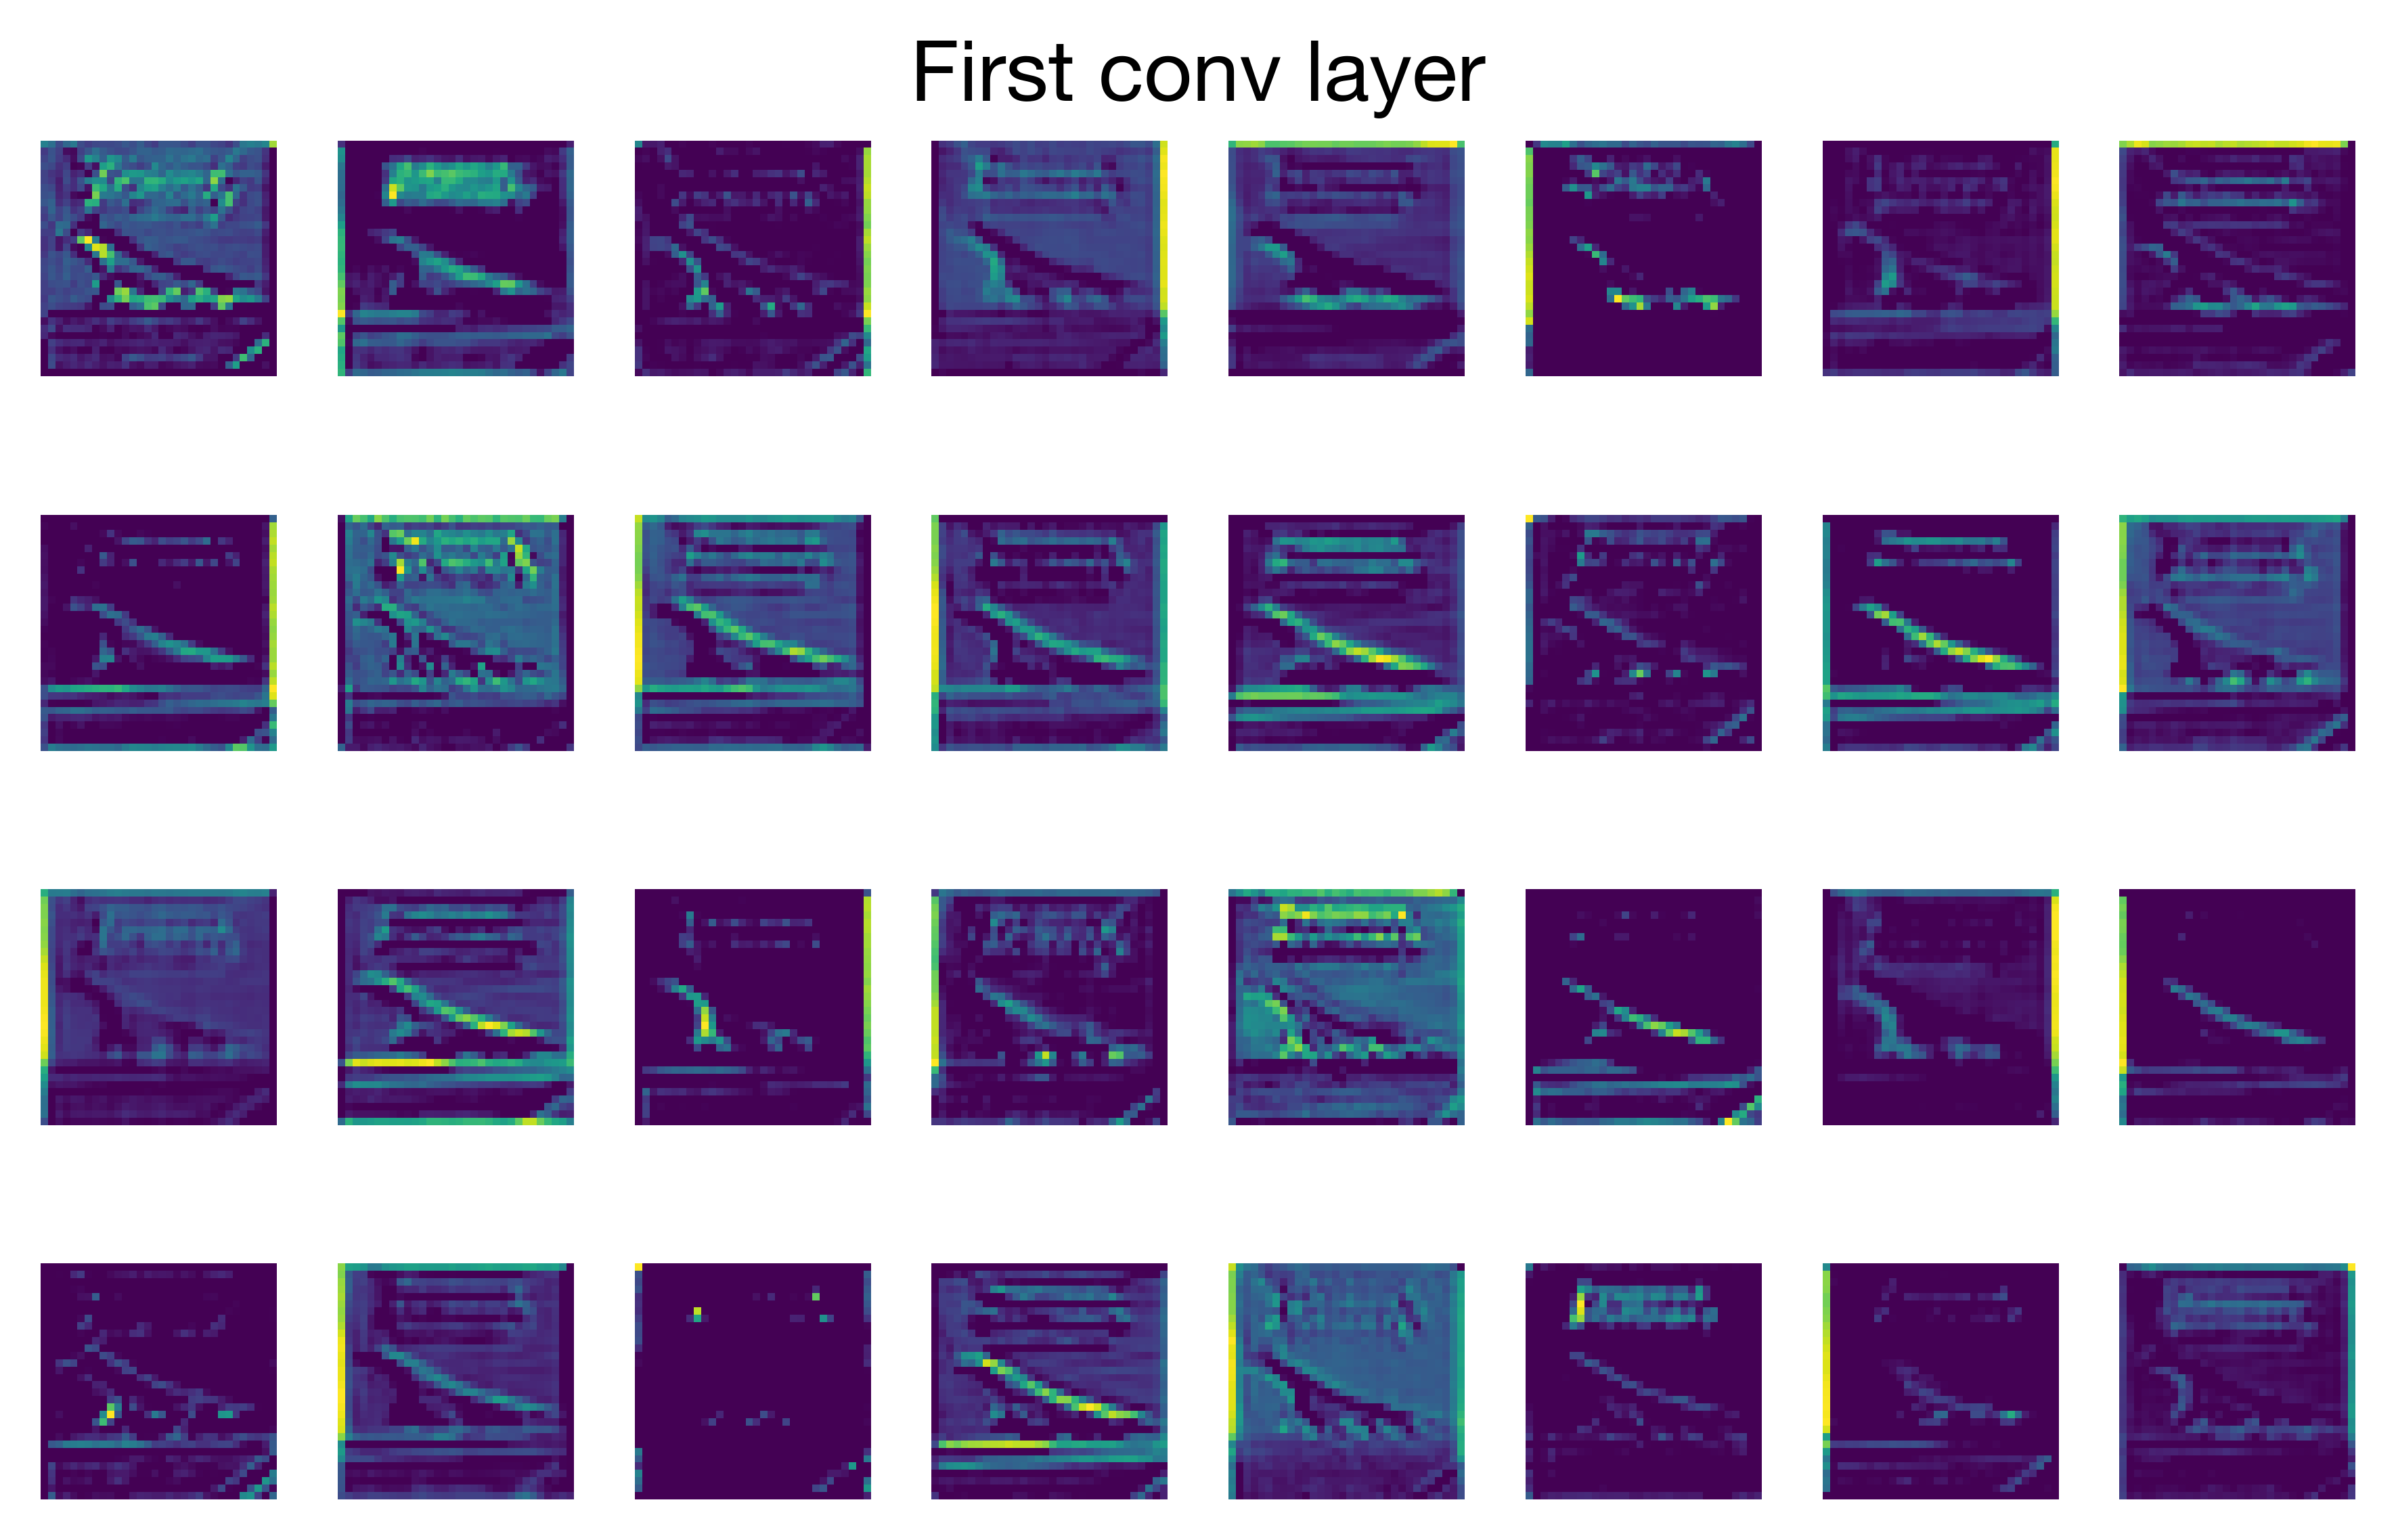

In [145]:
fig, axes = plt.subplots(ncols=8, nrows=4, dpi=300)
fig.suptitle('First conv layer')

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(conv1[0][:, :, i], interpolation='nearest')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

The above image grid shows the 32 outputs of the first convolutional layer of our network on the fourth testing image (the fighter jet).

We can see how the 32 outputs correspond to different features. For example, in the last row the third image from the right extracts the text part of the original image.

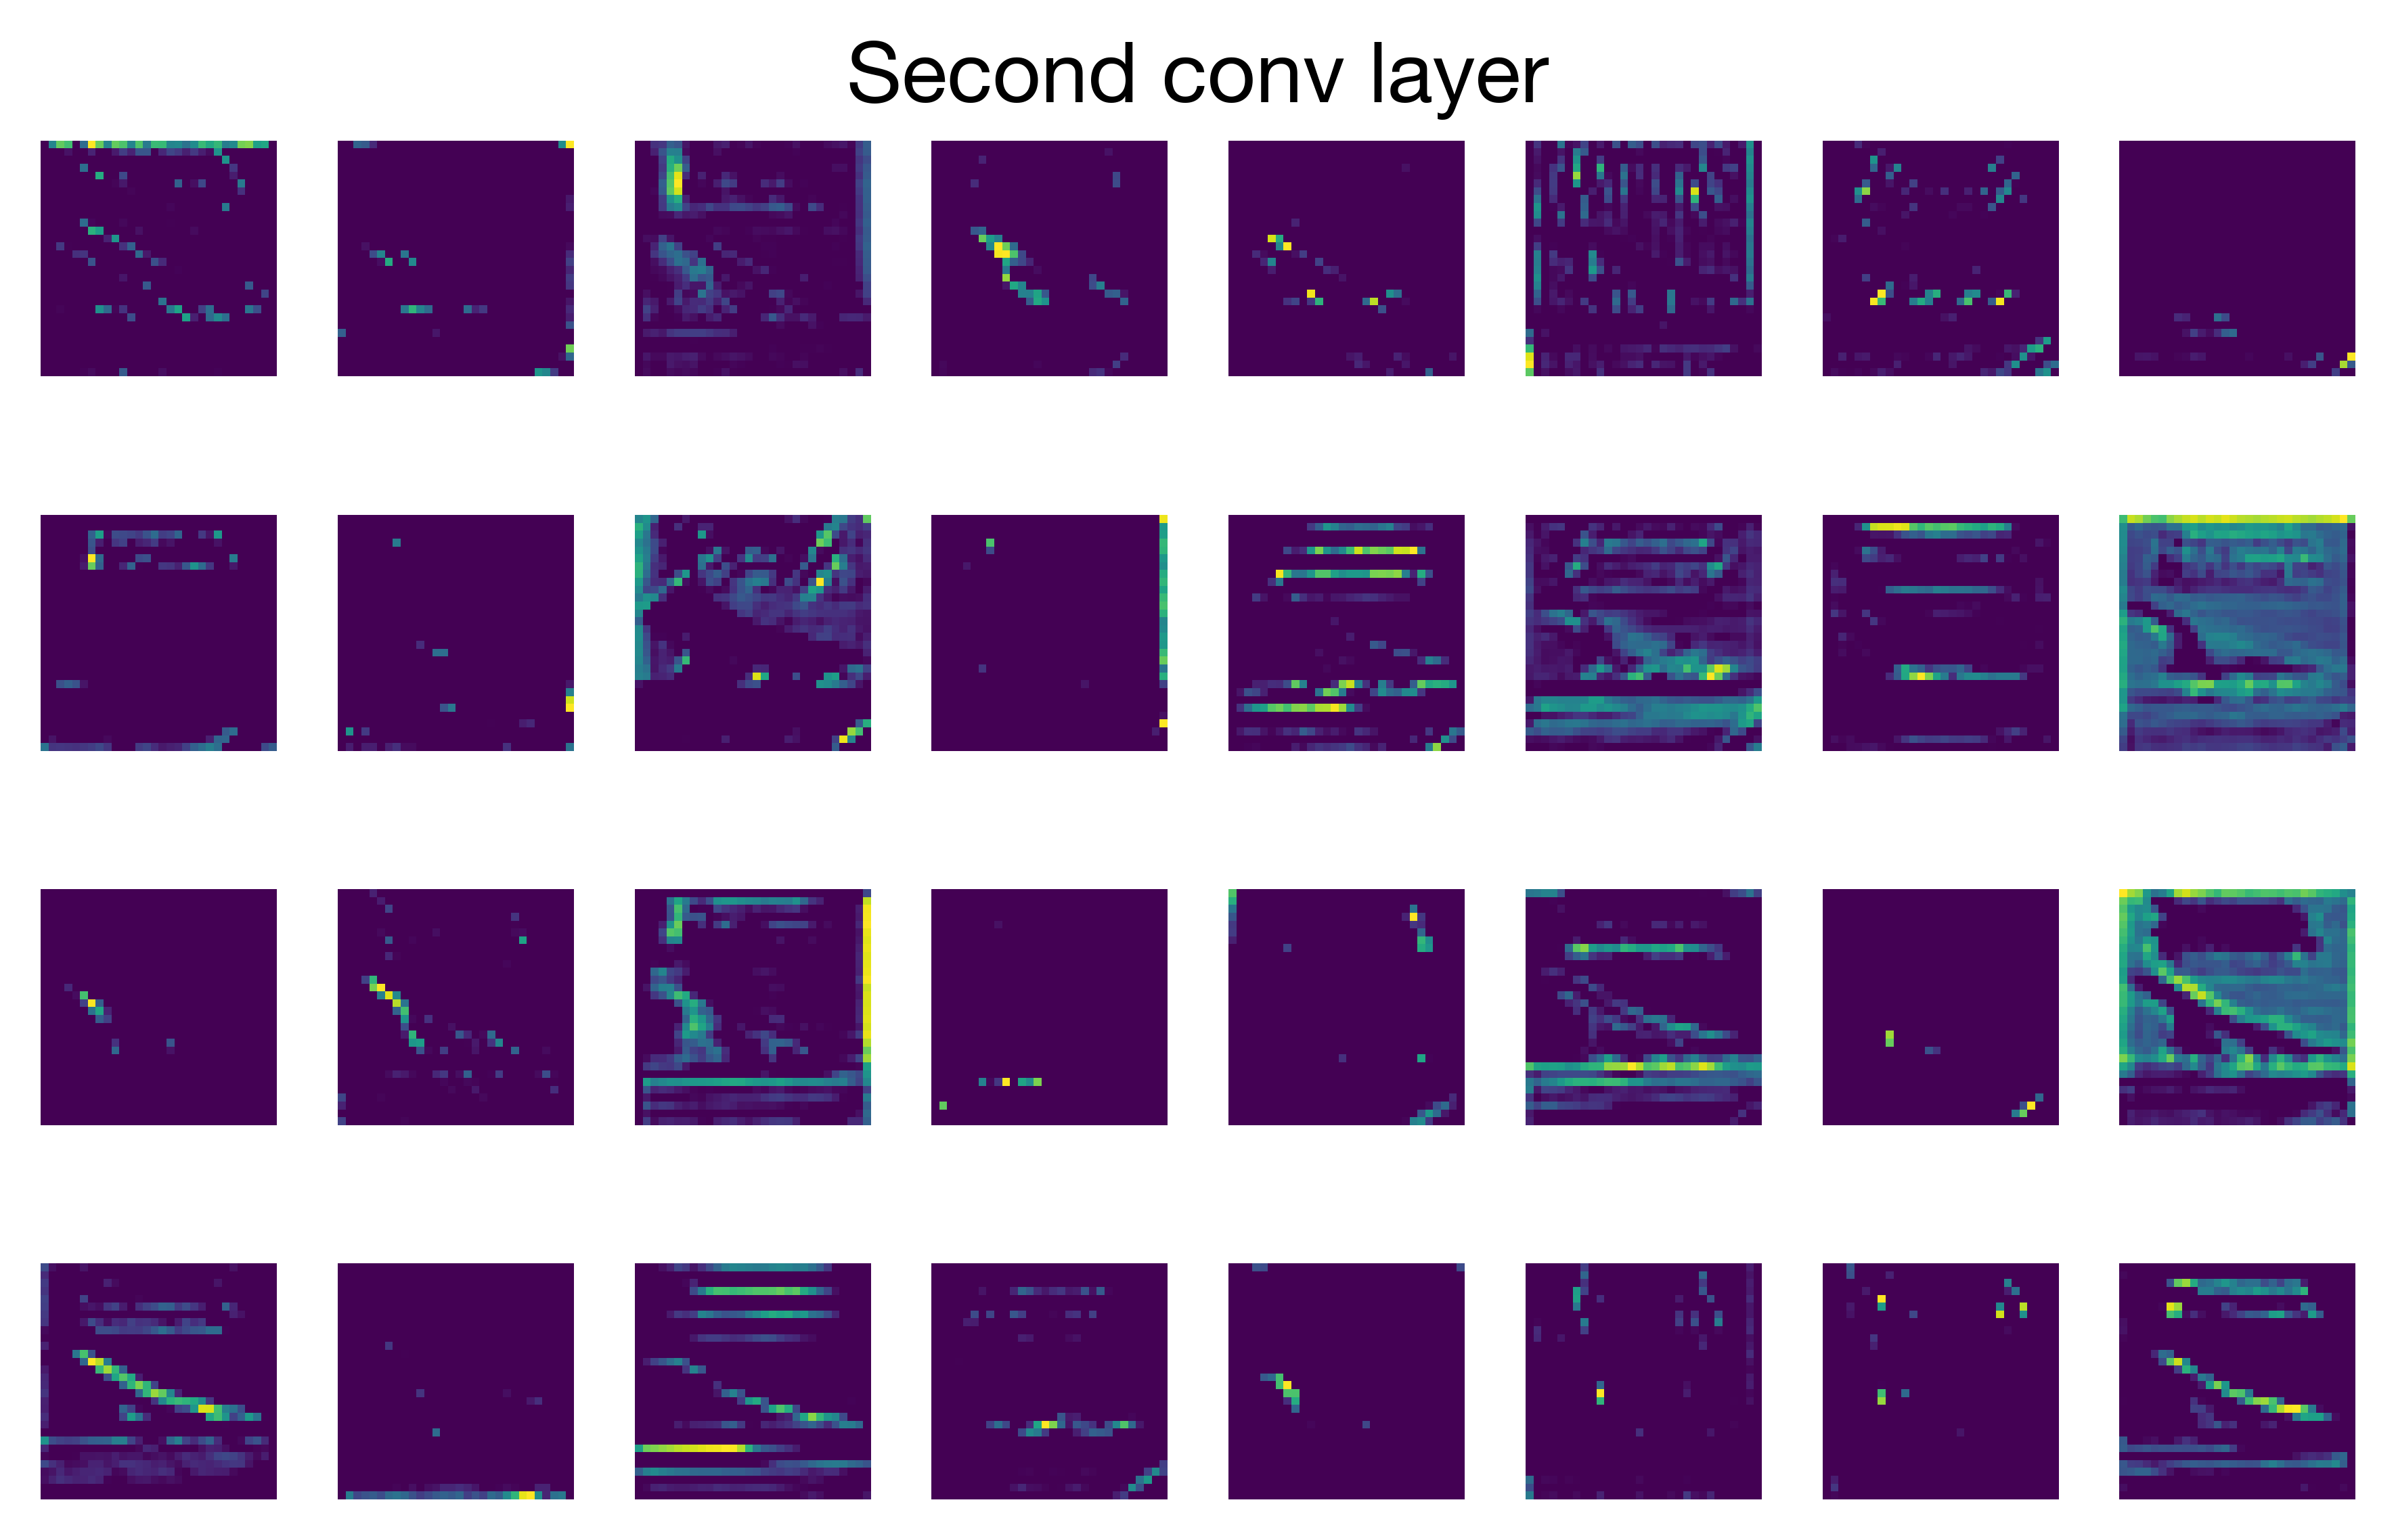

In [146]:
fig, axes = plt.subplots(ncols=8, nrows=4, dpi=300)
fig.suptitle('Second conv layer')

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(conv2[0][:, :, i], interpolation='nearest')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

For the second conv layer, we observe that some channels are mostly empty. There are only few channels where we are able to identify characteristics of the original image.

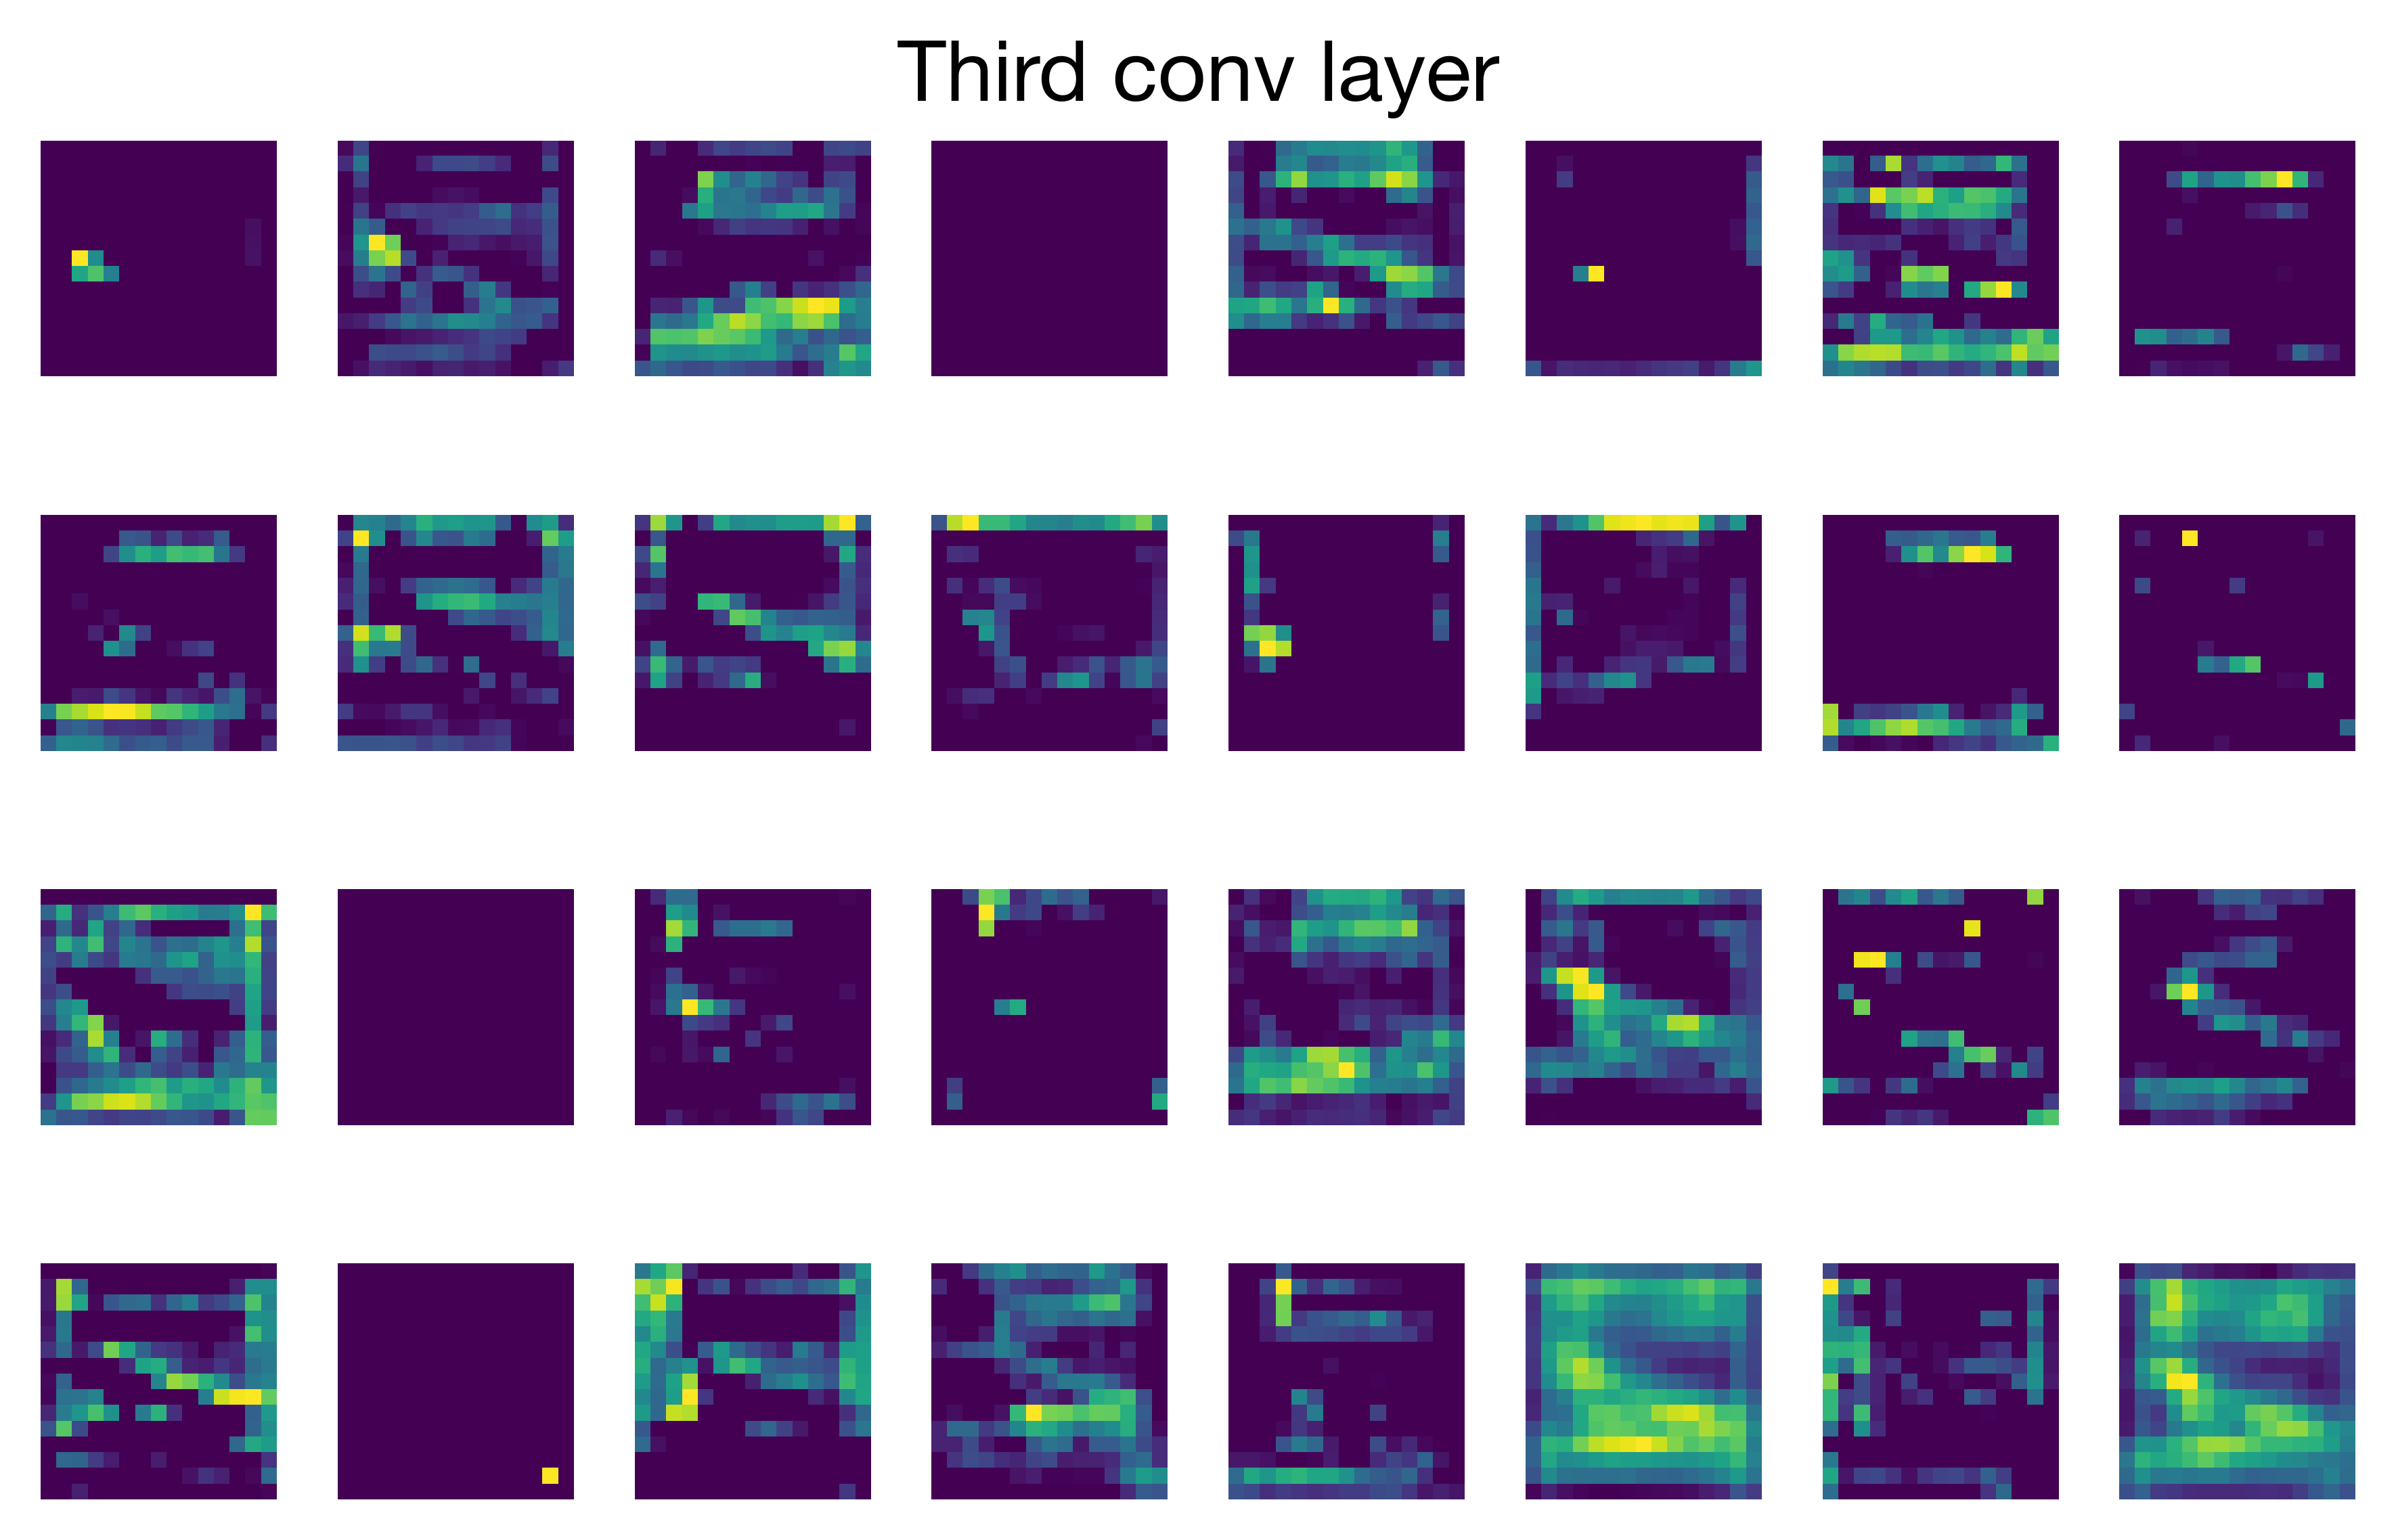

In [148]:
fig, axes = plt.subplots(ncols=8, nrows=4, dpi=300)
fig.suptitle('Third conv layer')

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(conv3[0][:, :, i], interpolation='nearest')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Let us compare the activations with the frog which was not classified correctly.

In [149]:
conv1, conv2, conv3, conv4 = intermediate.predict(x_test[4:5])

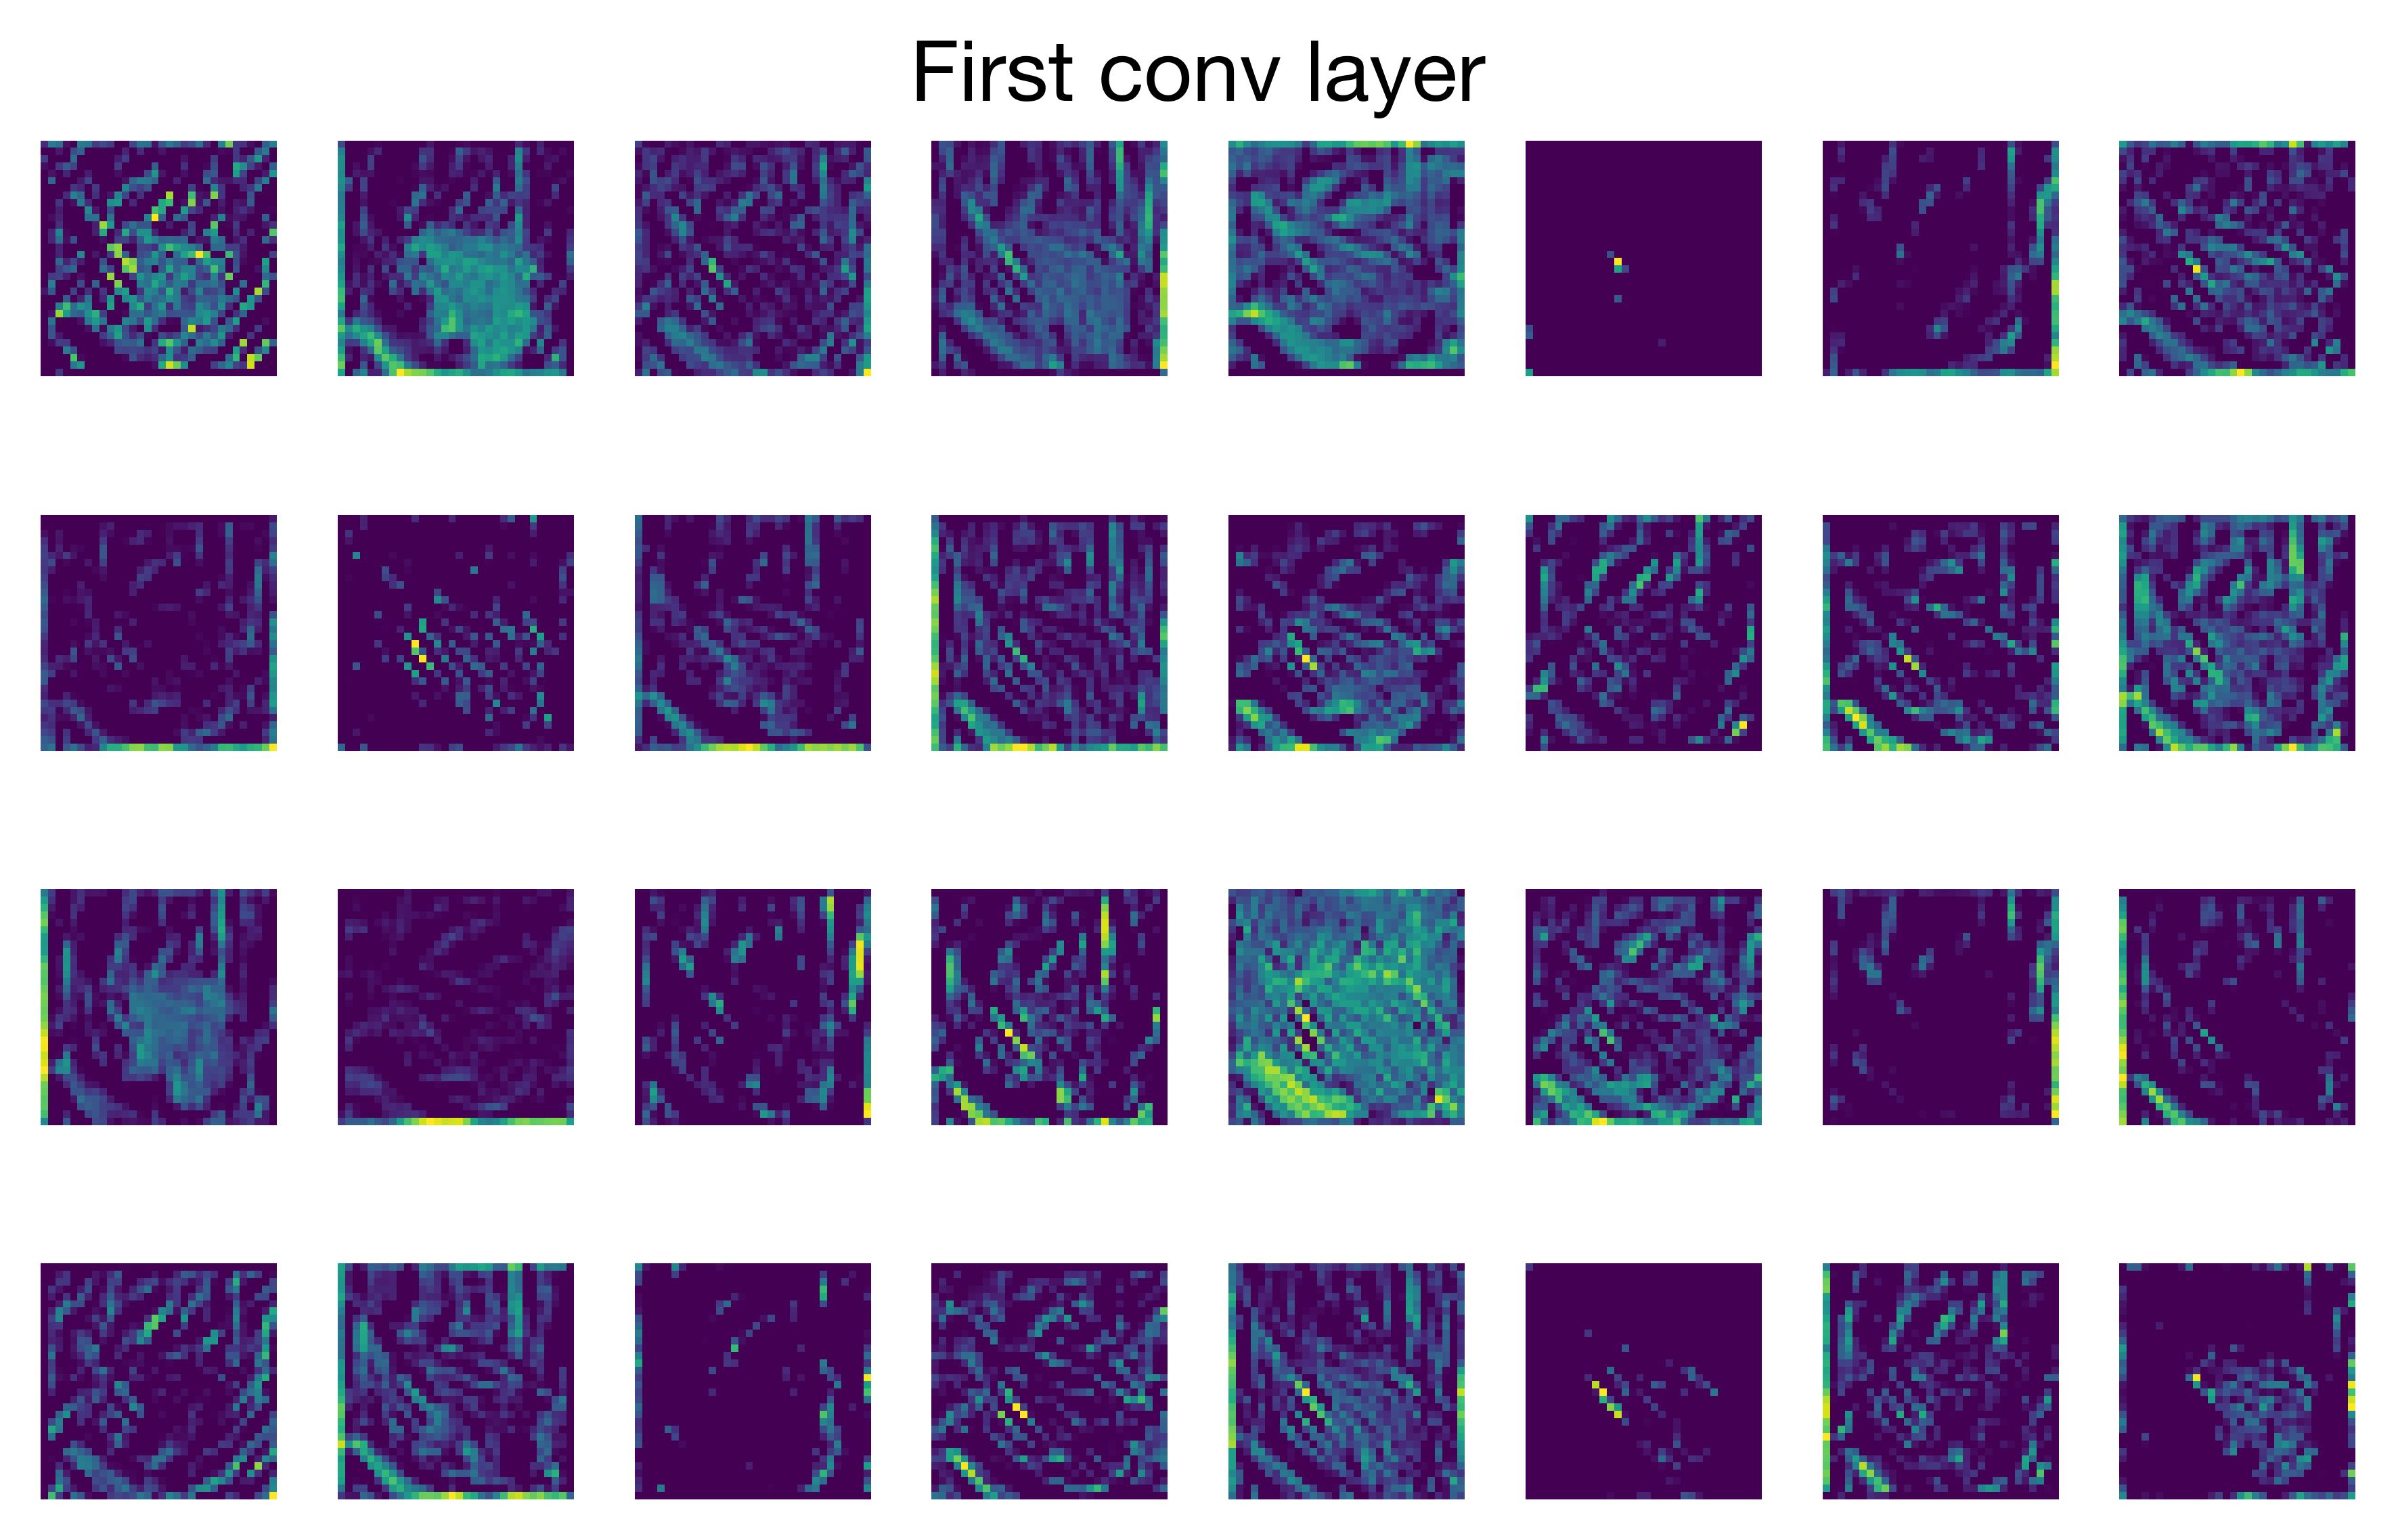

In [150]:
fig, axes = plt.subplots(ncols=8, nrows=4, dpi=300)
fig.suptitle('First conv layer')

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(conv1[0][:, :, i], interpolation='nearest')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

The outputs of the first layer do not look bad. In fact, in the last image looks like our frog without background.

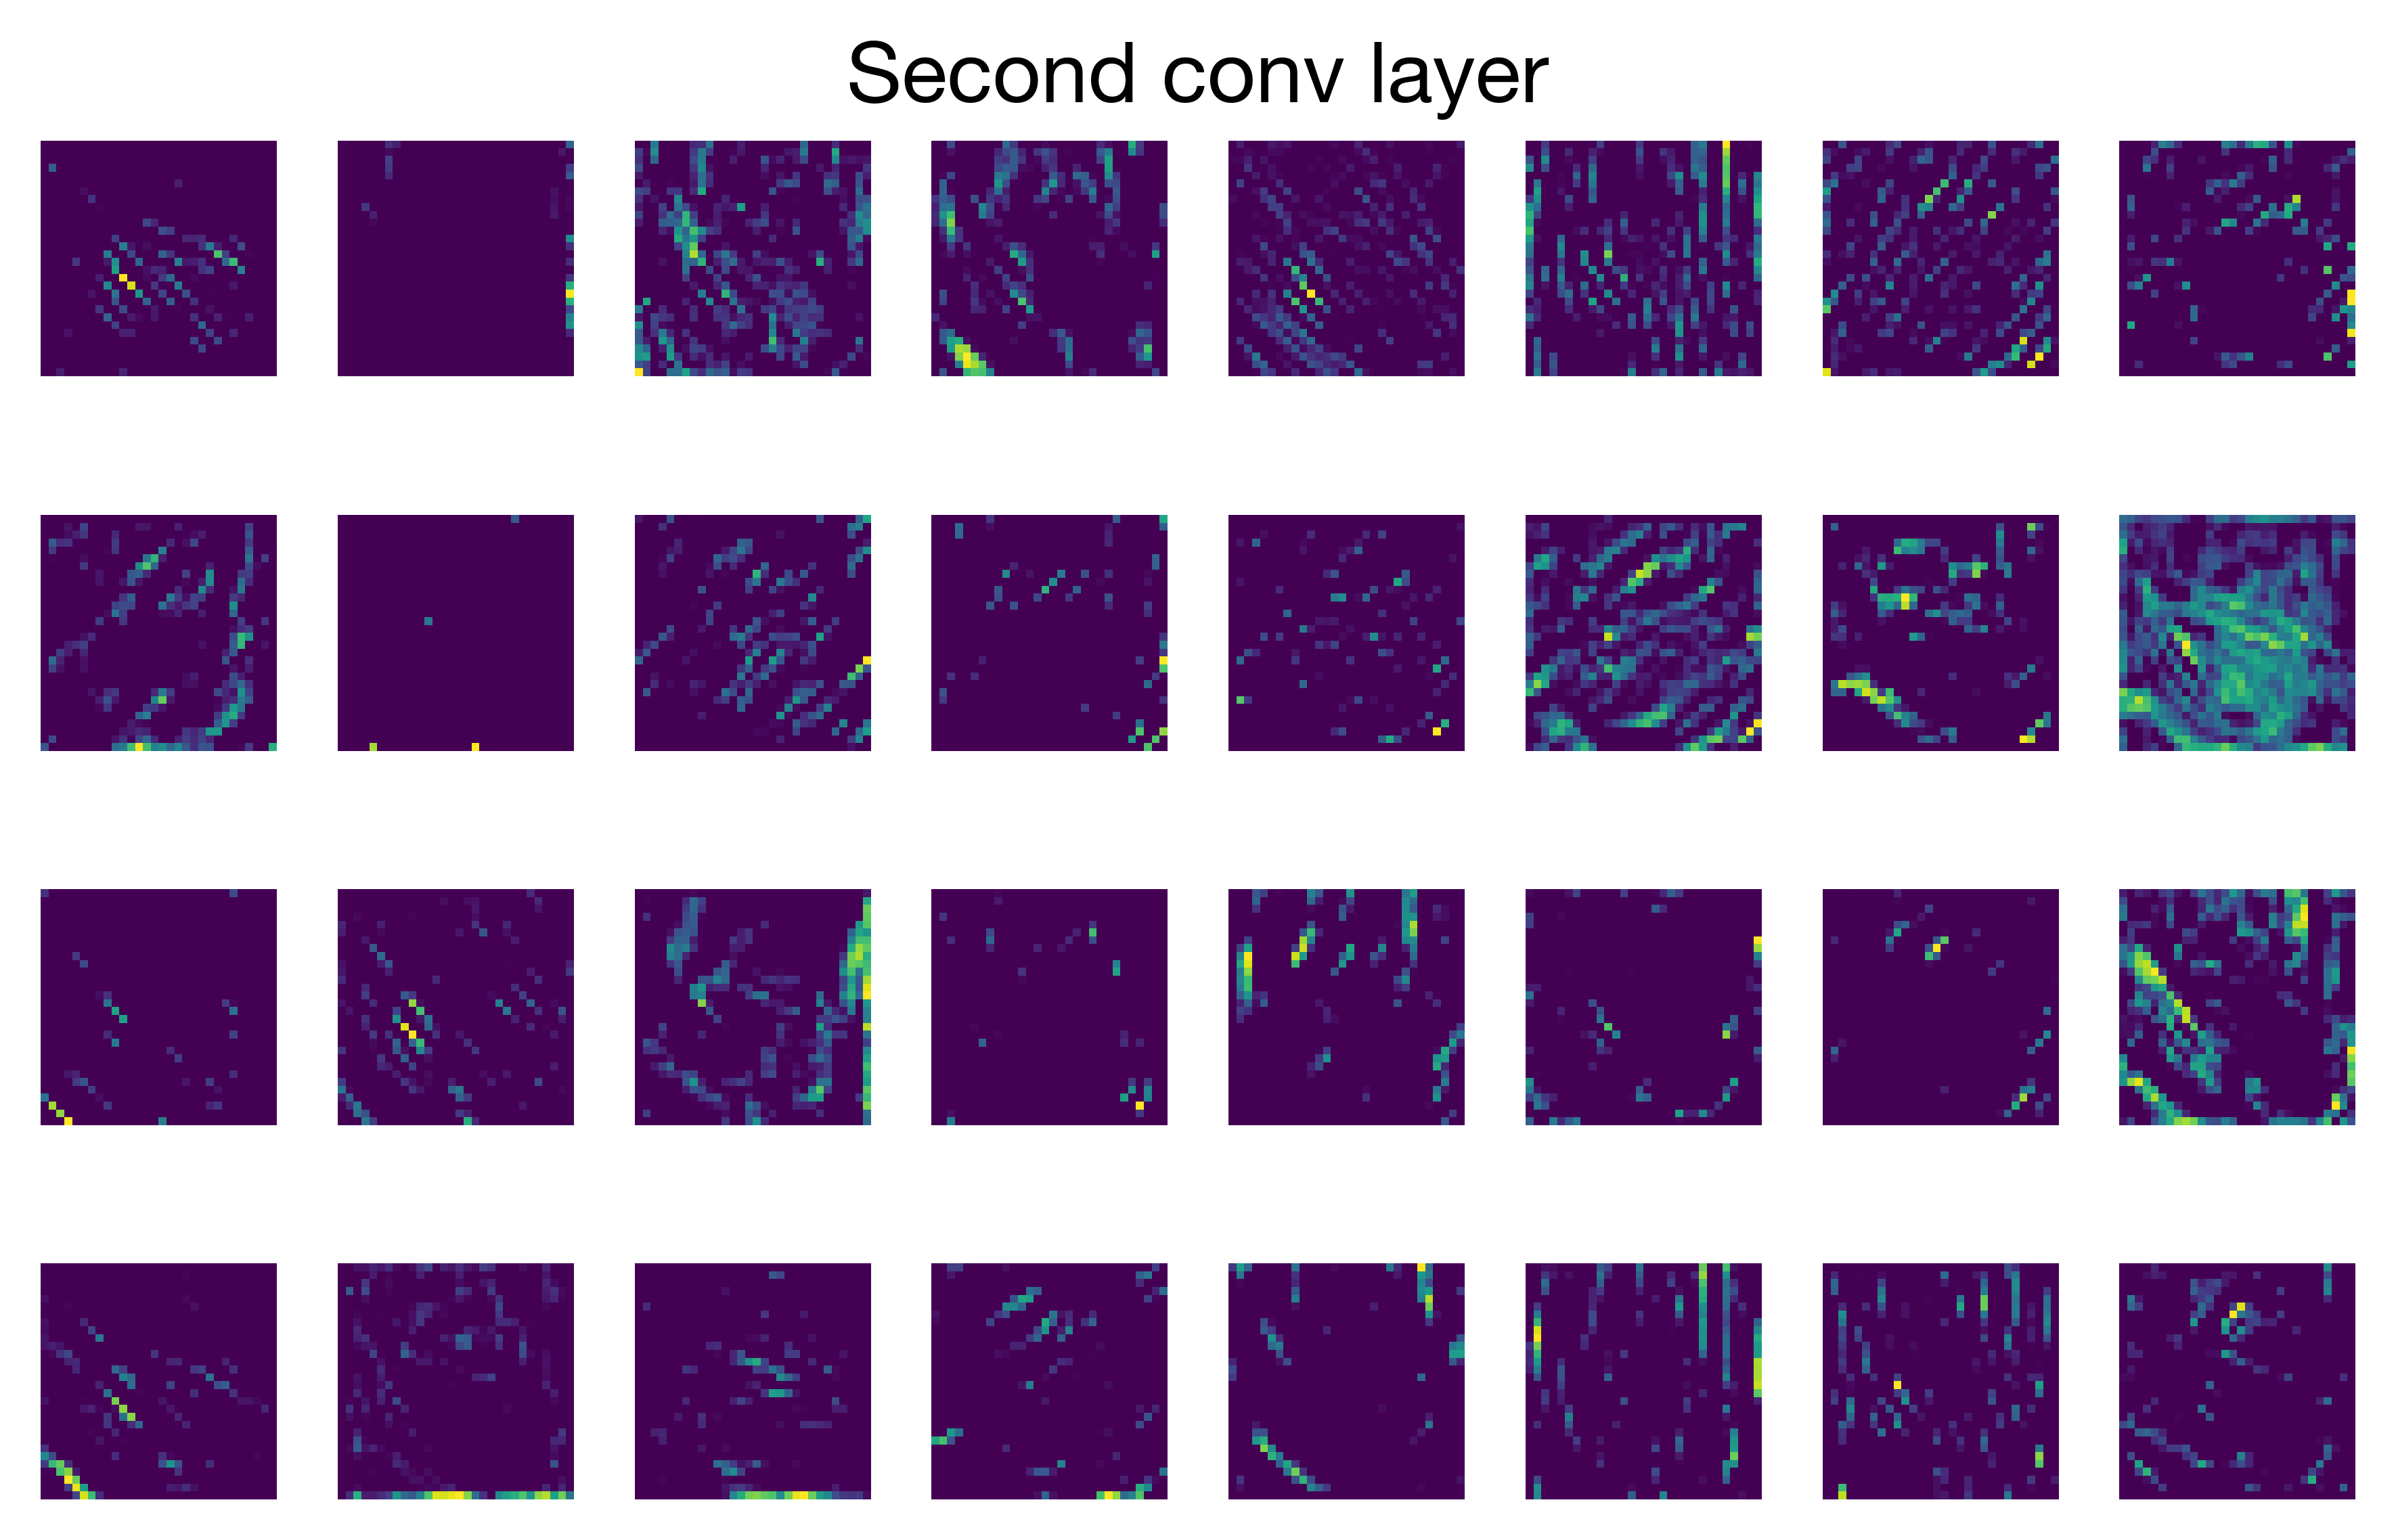

In [152]:
fig, axes = plt.subplots(ncols=8, nrows=4, dpi=300)
fig.suptitle('Second conv layer')

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(conv2[0][:, :, i], interpolation='nearest')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

The outputs of the second convolutional layer processing the frog do not look good. Probably, it is the second convolutional layer responsible for the error-prone classification of frog images.